# Recommendation Systems 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
import missingno as msno
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('../../')

from A_Model_Recommendation.ETL import ETL_class

In [3]:
path_rating = './../dataset/ratings/'
path_titles = './../dataset/titles/'
etl = ETL_class(path_titles, path_rating)

df_movies = etl.get_movies()
print(df_movies.shape)
df_movies.head(2)

(22998, 15)


,id,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,duration_int,duration_type,listed_in,description
0,as1,s1,movie,the grand seduction,don mckellar,"brendan gleeson, taylor kitsch, gordon pinsent",canada,2021-03-30,2014,g,113 min,113.0,min,"comedy, drama",a small fishing village must procure a local d...
1,as2,s2,movie,take care good night,girish joshi,"mahesh manjrekar, abhay mahajan, sachin khedekar",india,2021-03-30,2018,13+,110 min,110.0,min,"drama, international",a metro family decides to fight a cyber crimin...


In [4]:
df_ratings = etl.get_ratings()[['userId', 'rating', 'movieId']]
print(df_ratings.shape)
df_ratings.head()

(11024165, 3)


,userId,rating,movieId
0,1,1.0,as680
1,1,4.5,ns2186
2,1,5.0,hs2381
3,1,5.0,ns3663
4,1,5.0,as9500


In [5]:
df_ratings.isna().sum()

userId     0
rating     0
movieId    0
dtype: int64

# EDA

### Rating Report

In this first Exploration Data Analysis we start by bringing in reports made by *pandas_profiling* to find any particularity can catch our attention. But before that we transform in *df_ratings* the columns movieId, i.e., instead of employing string data we better handle it as numeric data.

In [6]:
# for that we can use the sklearn method's preprocessing to convert into numeric data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df_ratings['movieId_le'] = le.fit_transform(df_ratings['movieId'])
df_ratings.head()

,userId,rating,movieId,movieId_le
0,1,1.0,as680,6445
1,1,4.5,ns2186,15510
2,1,5.0,hs2381,12654
3,1,5.0,ns3663,17151
4,1,5.0,as9500,9446


In [7]:
# let's create the report on ratings
profile_rating = ProfileReport(df_ratings, title='Pandas Profiling Report', explorative=True)
profile_rating.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In the previous report would be interesting to point out that there's no much correlation between columns in the dataframe for ratings, where the correlation matrix is:
$$
\begin{matrix}
 & \text{userId} & \text{rating} & \text{timestamp} & \text{movieId_le} \\
\text{userId} & 1.0 & 0.005 & 0.004 & -0.0004\\
\text{rating} & 0.005 & 1.0 & 0.01 & 0.0005\\
\text{timestamp} & 0.004 & 0.01 & 1.0 & 0.0003\\
\text{movieId_le} & -0.0004 & 0.0005 & 0.0003 & 1.0\\
\end{matrix}
$$<br>
This allows us to understand that perform a surpervised model on this data may be not the best option, better to use a unsupervised model.

In [ ]:
corr_rating = df_ratings.corr()
corr_rating

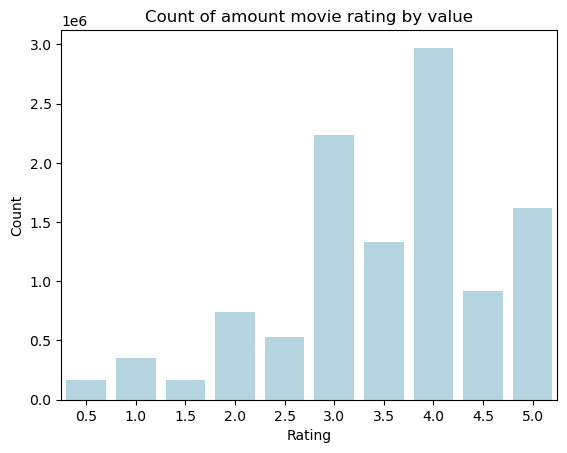

In [7]:
# On the other hand, let's see grafical relation between variable
# This firt graphs' going to tell us about the count of rating
df_cr = df_ratings[['rating', 'movieId_le']].groupby('rating').agg(['count']).reset_index()

plt.figure()
sns.barplot(x='rating', y=df_cr.columns[-1], data=df_cr, color='lightblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Count of amount movie rating by value')
plt.show()

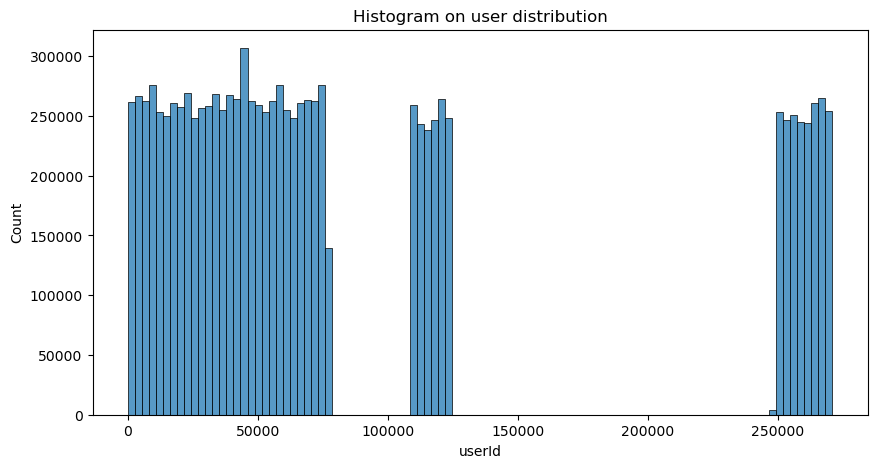

In [38]:
# let's see the distribution on users
plt.figure(figsize=(10,5))
sns.histplot(data=df_ratings['userId'], bins=100)
plt.xlabel('userId')
plt.ylabel('Count')
plt.title('Histogram on user distribution')
plt.show()

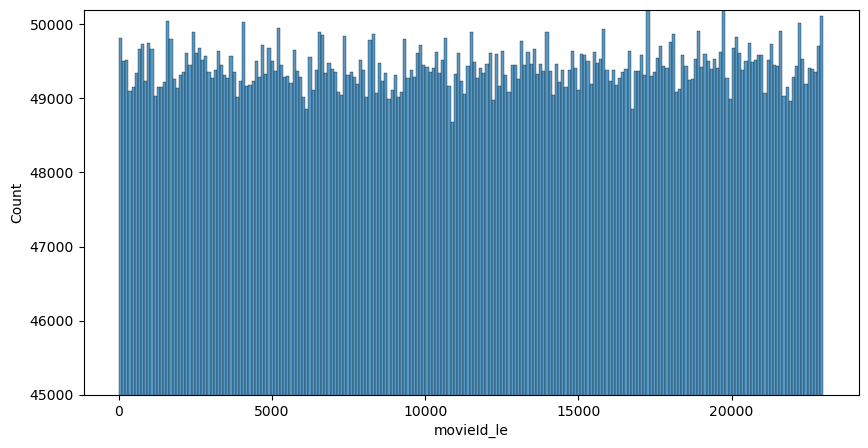

In [40]:
# now this graph is the distributon of the movies
plt.figure(figsize=(10,5))
sns.histplot(data=df_ratings['movieId_le'])
plt.ylim(45000,50200)
plt.show()

These three figures let us to know how is the distribution on the data. First, the value of ranking is higher at 3 and 4, so we can expect the mean of ratings per movie is in the interval (3,4). About to movie and user distribution we can appreciate they are uniform, so each user grades almost the same amount of movies, and each movie has almost the same amount of grades.

### Movie Report

Now let's move on dataset of movies.

In [11]:
profile_movies = ProfileReport(df_movies, title='Pandas Profiling Report', explorative=True)
profile_movies.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In this case, many alarms appear because there're many missing values, mainly in columns such as 'director', 'cast', 'country' and 'date_added'. 

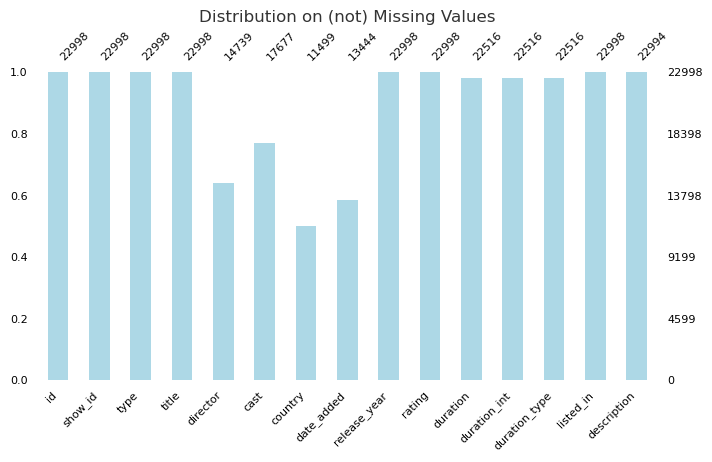

In [10]:
# let's visualize the distribution on missing values and the position the have into the table
msno.bar(df_movies, color='lightblue', figsize=(8,4), fontsize=8)
plt.title('Distribution on (not) Missing Values', alpha=0.8)
plt.show()

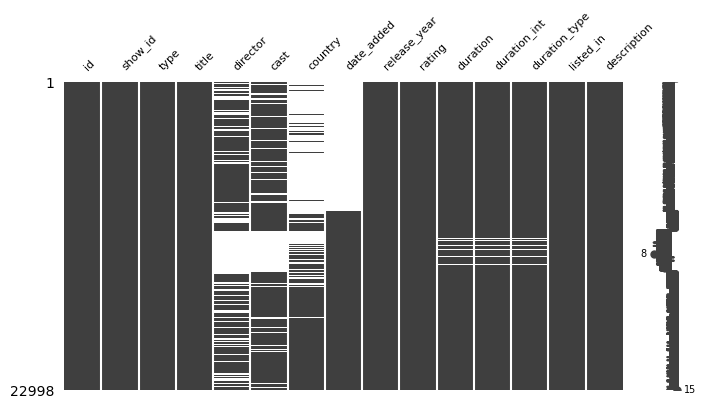

In [11]:
# and here it's the distribution into the dataframe
msno.matrix(df_movies, figsize=(8,4), fontsize=8)
plt.show()

## EDA on Votes and Popularity

In this part we goint to explore data, in the way to find the best movies based on votes and popularity (here we shall define a popularity feature). To measure the votes we use:
$$
W = \frac{R\cdot\nu + C\cdot m}{\nu + m},
$$
where each parameter means:
$$
W = \text{Weight Rating} \\
R = \text{Average for the movie as a number from 0 to 5} \\
\nu = \text{Number of votes for the movie} \\
m = \text{Minimun votes required to be listed in the Top 30\%} \\
C = \text{The mean vote across the whole report}
$$
Thus, let's start by defining this variables

In [12]:
df_W = df_ratings[['movieId', 'rating']]
df_W = df_W.groupby(['movieId']).agg(['mean', 'count', 'sum'])
df_W.rename(columns={'sum': 'popularity'}, inplace=True)
df_W.reset_index(inplace=True)
print(df_W.shape)
df_W.head()

(22998, 4)


movieId    rating                 
               mean count popularity
0     as1  3.467131   502     1740.5
1    as10  3.439571   513     1764.5
2   as100  3.609302   430     1552.0
3  as1000  3.556701   485     1725.0
4  as1001  3.585288   469     1681.5

Here we have defined the popularity as the overall rating sum by movie, which it does make sense, since any movie is watched few times then this movie is not popular.

In [13]:
# creating the variables
R = df_W[df_W.columns[1]]
v = df_W[df_W.columns[2]]
m = df_W[df_W.columns[2]].quantile(0.90)
C = df_W[df_W.columns[1]].mean()

df_W['mean_weight'] = ((R*v) + (C*m)) / (v+m)
print(df_W.shape)
df_W.head()

(22998, 5)


movieId    rating                  mean_weight
               mean count popularity            
0     as1  3.467131   502     1740.5    3.500451
1    as10  3.439571   513     1764.5    3.486231
2   as100  3.609302   430     1552.0    3.568255
3  as1000  3.556701   485     1725.0    3.544814
4  as1001  3.585288   469     1681.5    3.558356

In [14]:
# let's bring in the movie's title
df_merge = df_W.merge(df_movies[['id', 'title']], left_on='movieId', right_on='id').drop(columns=['id'])
old_columns = df_merge.columns
new_columns = ['movieId', 'vote_mean', 'vote_count', 'popularity', 'mean_weight', 'title']
df_merge.rename(columns={o:n for (o, n) in zip(old_columns, new_columns)}, inplace=True)
df_merge['id'] = np.arange(1,df_merge.shape[0] +1, 1)
df_merge.head()

,movieId,vote_mean,vote_count,popularity,mean_weight,title,id
0,as1,3.467131,502,1740.5,3.500451,the grand seduction,1
1,as10,3.439571,513,1764.5,3.486231,david's mother,2
2,as100,3.609302,430,1552.0,3.568255,wilder napalm,3
3,as1000,3.556701,485,1725.0,3.544814,sinbad: make me wanna holla,4
4,as1001,3.585288,469,1681.5,3.558356,simple gifts: the chamber music society at sha...,5


In [15]:
df_merge.columns

Index(['movieId', 'vote_mean', 'vote_count', 'popularity', 'mean_weight',
       'title', 'id'],
      dtype='object')

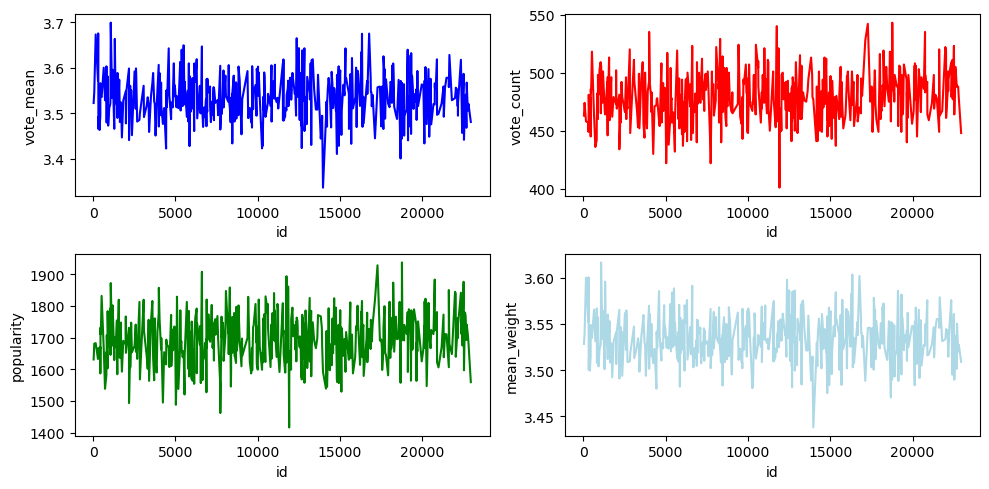

In [36]:
plt.figure(figsize=(10,5))
color = ['blue', 'red', 'green', 'lightblue']
for ii, c in enumerate(df_merge.columns[1:5]):
    plt.subplot(2,2,ii+1)
    sns.lineplot(x='id', y=c, data=df_merge.sample(n=500, random_state=0), color=color[ii])
plt.tight_layout()
plt.show()

Again we find an almost uniformity on data.

In [30]:
movie_sorted_ranking = df_merge.sort_values(['mean_weight'], ascending=False)
movie_sorted_ranking.head()

,movieId,vote_mean,vote_count,popularity,mean_weight,title,id
12422,hs2172,3.717143,525,1951.5,3.626895,the man who killed hitler and then the bigfoot,12423
9586,as9627,3.724512,461,1717.0,3.624437,thalaivii (telugu),9587
16638,ns3200,3.709278,485,1799.0,3.619411,space jungle,16639
11128,hs1007,3.703061,490,1814.5,3.616806,the haunting in connecticut,11129
12510,hs2251,3.702648,491,1818.0,3.616689,masterchef junior,12511


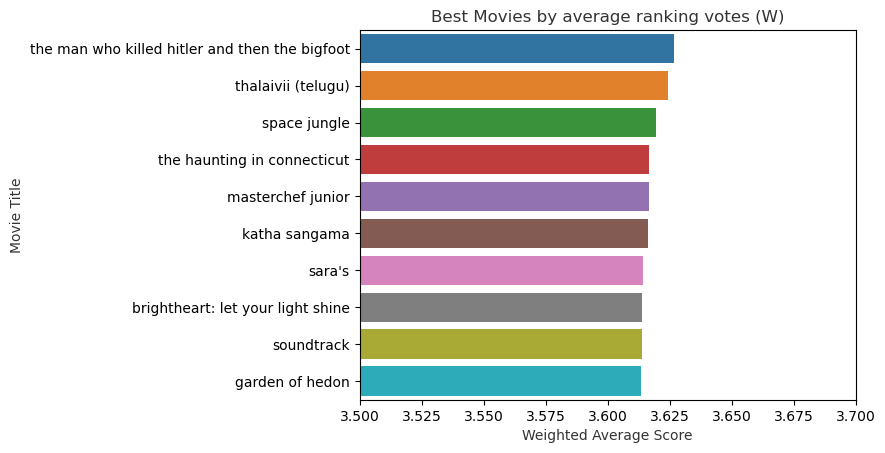

In [31]:
plt.figure()
ax = sns.barplot(x='mean_weight', y='title', data=movie_sorted_ranking.head(10))
plt.xlim(3.5,3.7)
plt.title('Best Movies by average ranking votes (W)', alpha=0.8)
plt.xlabel('Weighted Average Score', alpha=0.8)
plt.ylabel('Movie Title', alpha=0.8)
plt.show()

Here we find 'the man who killed hitler...' is in general de movie most popular based on the average weighted metric. Following by thalaivii, space jungle, etc.

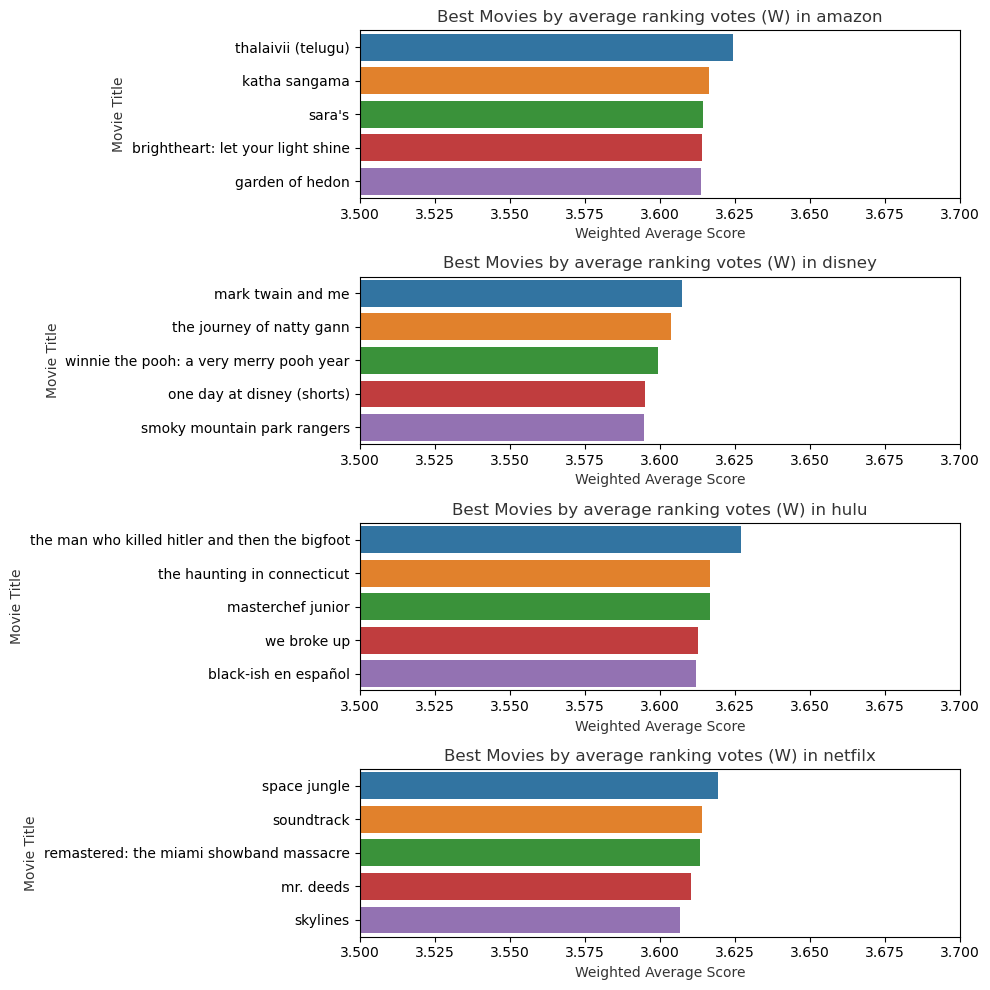

In [32]:
# let's see the best movies by platform
plt.figure(figsize=(10,10))
platform = ['amazon', 'disney', 'hulu', 'netfilx']
for ii, m in enumerate(platform):
    plt.subplot(4,1,ii+1)
    begins = m[0]
    df_platform = movie_sorted_ranking.loc[movie_sorted_ranking.movieId.str.contains('^{}'.format(begins))].head()
    ax = sns.barplot(x='mean_weight', y='title', data=df_platform)
    plt.xlim(3.5,3.7)
    plt.title('Best Movies by average ranking votes (W) in '+str(m), alpha=0.8)
    plt.xlabel('Weighted Average Score', alpha=0.8)
    plt.ylabel('Movie Title', alpha=0.8)
plt.tight_layout()
plt.show()

So it's in the previous figure we see where come the best titles from.<br>
And what about votes based on popularity? let'see

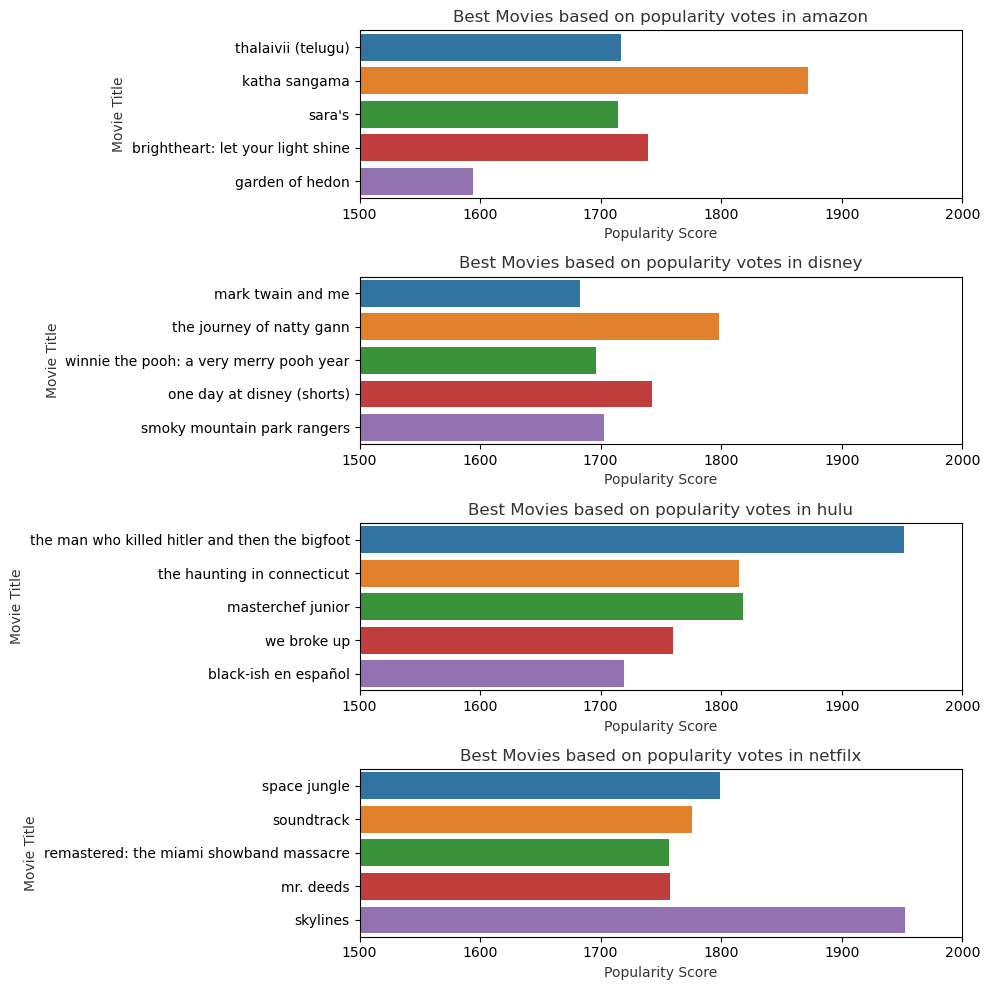

In [33]:
plt.figure(figsize=(10,10))
platform = ['amazon', 'disney', 'hulu', 'netfilx']
for ii, m in enumerate(platform):
    plt.subplot(4,1,ii+1)
    begins = m[0]
    df_platform = movie_sorted_ranking.loc[movie_sorted_ranking.movieId.str.contains('^{}'.format(begins))].head()
    ax = sns.barplot(x='popularity', y='title', data=df_platform)
    plt.xlim(1500,2000)
    plt.title('Best Movies based on popularity votes in '+str(m), alpha=0.8)
    plt.xlabel('Popularity Score', alpha=0.8)
    plt.ylabel('Movie Title', alpha=0.8)
plt.tight_layout()
plt.show()

Now based on popularity we can apreciate the variance is higher than one of average-weight votes. However, there's a important correlation between this two 'metrics'.